In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

In [3]:
# RunRules for m100
nodes = 8 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '240GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_PrExIn',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# BSE analysis for Stanene monolayer

We compute the first excitonic energy and the absorption spectrum of the monolayer Stanene within the BSE framework.

## Convergence analysis in function of the number of bands

We study the convergence of the low energy part of the absorption spectrum.
The GW correction are included using a scissor on top of the DFT gap.

We perform this analysis for the 18x18x1 k-sampling. We use the RIM_W, the study of the 
convergence of the exciton binding energy with and without the RIM_W will be performed later.

In [54]:
dft_gap = 0.088
gw_gap = 0.184 #
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)

kpoints = 18

scissor 0.096


In [56]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [[25,30],[25,32]]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
for bsebands in BSEBands:
    idd = 'abs-bse-bsebands_%s_%s-bsengblk_%s'%(bsebands[0],bsebands[1],BSENGBlk)
    inp.set_array_variables(BSEBands=bsebands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [57]:
study.ids

['abs-bse-bsebands_25_30-bsengblk_3.0', 'abs-bse-bsebands_25_32-bsengblk_3.0']

In [58]:
#study.runs[0]

In [59]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_3.0
Task [0] ended 
 
Run the task [1] 
Skip the run of abs-bse-bsebands_25_32-bsengblk_3.0
Task [1] ended 
 


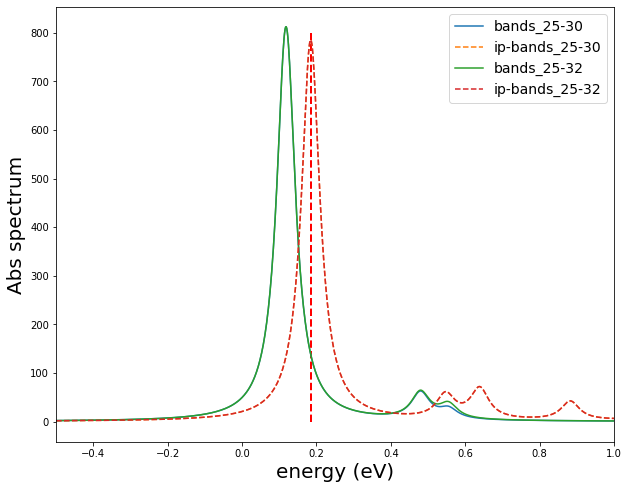

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSEBands):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    alpha_o_im = data['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bands_%s-%s'%(b[0],b[1])) 
    ax.plot(energy,alpha_o_im,linestyle='--',label='ip-bands_%s-%s'%(b[0],b[1])) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
#ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that also the exciton binding energy is well converged w.r.t. the number of bands

In [64]:
exc_eng = [results[ind].data['Esort_q1_slepc_bse']['energy'] for ind in range(len(BSEBands))]
exc_eng

[array([0.114345, 0.115693, 0.118504, 0.477787, 0.479647, 0.511578,
        0.512583, 0.544306, 0.5547  ]),
 array([0.114167, 0.115673, 0.118485, 0.477604, 0.479527, 0.51005 ,
        0.511133, 0.544296, 0.554687])]

In [65]:
bind_eng = [gw_gap-exc_eng[ind][0] for ind in range(len(BSEBands))]
bind_eng

[0.069655, 0.06983299999999999]

## Convergence analysis in function of BSENGBlk

In [67]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = [3.0,4.0] # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
for bsengblk in BSENGBlk:
    idd = 'abs-bse-bsebands_%s_%s-bsengblk_%s'%(BSEBands[0],BSEBands[1],bsengblk)
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [68]:
study.ids

['abs-bse-bsebands_25_30-bsengblk_3.0', 'abs-bse-bsebands_25_30-bsengblk_4.0']

In [69]:
#study.runs[1]

In [70]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_3.0
Task [0] ended 
 
Run the task [1] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_4.0
Task [1] ended 
 


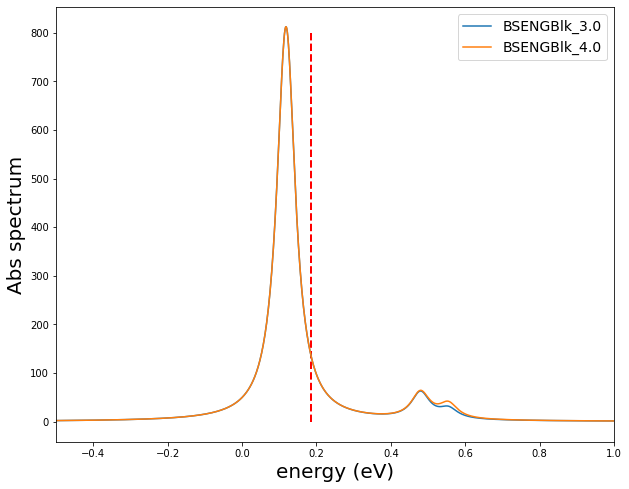

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSENGBlk):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='BSENGBlk_%s'%b) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
#ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that also the exciton binding energy is well converged w.r.t. the number of bands

In [39]:
exc_eng = [results[ind].data['Esort_q1_slepc_bse']['energy'] for ind in range(len(BSENGBlk))]
exc_eng

[array([0.114345, 0.115693, 0.118504, 0.477787, 0.479647, 0.511578,
        0.512583, 0.544306, 0.5547  ]),
 array([0.11435 , 0.115693, 0.118505, 0.477778, 0.479639, 0.511603,
        0.512607, 0.544308, 0.554705])]

In [40]:
bind_eng = [gw_gap-exc_eng[ind][0] for ind in range(len(BSENGBlk))]
bind_eng

[0.069655, 0.06965]

## Abs spectrum using the true GW band structure

In [42]:
ndbQP = 'pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500/ndb.QP'

In [46]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,32]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field) #,KfnQP_E=[scissor,1.,1.]
inp.set_scalar_variables(KfnQPdb='E < %s'%ndbQP)

inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     

idd = 'abs-bse-gw-bsebands_%s_%s-bsengblk_%s'%(BSEBands[0],BSEBands[1],BSENGBlk)
inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [53]:
#study.runs[0]

In [48]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F abs-bse-gw-bsebands_25_32-bsengblk_3.0.in -J "abs-bse-gw-bsebands_25_32-bsengblk_3.0,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles-nbnds_500" -C abs-bse-gw-bsebands_25_32-bsengblk_3.0
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500/ ; sbatch job_abs-bse-gw-bsebands_25_32-bsengblk_3.0.sh
computation abs-bse-gw-bsebands_25_32-bsengblk_3.0 is running...
computation abs-bse-gw-bsebands_25_32-bsengblk_3.0 ended
Run performed in 08m-37s
Task [0] ended 
 


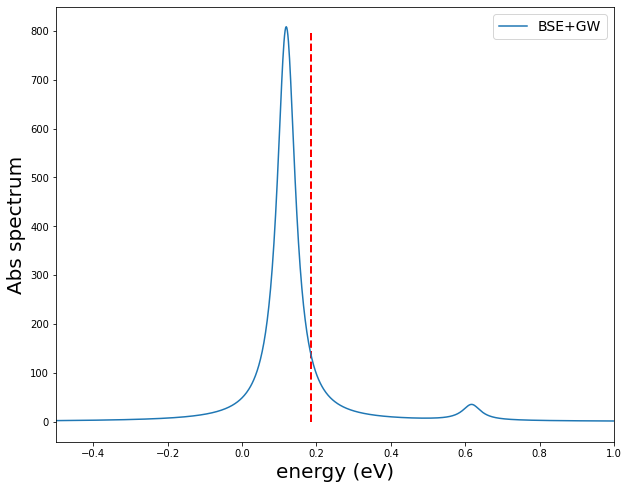

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['alpha_q1_slepc_bse']
energy = data['energy']
alpha_im = data['alpha_imag']
ax.plot(energy,alpha_im,label='BSE+GW') 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

In [51]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.115213, 0.116287, 0.119093, 0.576244, 0.606878, 0.61707 ,
       0.618265, 0.620927])

In [52]:
bind_eng = gw_gap-exc_eng[0]
bind_eng

0.068787

The effect of including the GW correction is a small modification of the peak at 0.6 eV.

## Convergence analysis in function of the k-points sampling

We perform the convergence analysis of the abs spectrum and of the exciton binding energy
in function of the k-sampling. We perform this analysis both with and without the RIM_W.

At this level we use the bands from 25 to 30 with the scissor correction.

In [19]:
dft_gap = 0.088
gw_gap = 0.184 #
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)

kpoints = [18,42,60,72]

scissor 0.096


In [27]:
RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=4,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%k
    #inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
    inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
    inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
    inp.set_scalar_variables(BSEprop= 'abs esrt')
    inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
    idd = 'abs-bse-kpoints_%s'%k
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

for k in kpoints:
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%k
    #inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
    inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
    #inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
    inp.set_scalar_variables(BSEprop= 'abs esrt')
    inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
    idd = 'abs-bse-norimw-kpoints_%s'%k
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=True)

Initialize a Dataset with 4 parallel tasks


In [28]:
study.ids

['abs-bse-kpoints_18',
 'abs-bse-kpoints_42',
 'abs-bse-kpoints_60',
 'abs-bse-kpoints_72',
 'abs-bse-norimw-kpoints_18',
 'abs-bse-norimw-kpoints_42',
 'abs-bse-norimw-kpoints_60',
 'abs-bse-norimw-kpoints_72']

In [22]:
#study.runs[2]

In [29]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7]] 

Run the task [0, 1, 2, 3] 
Skip the run of abs-bse-kpoints_18Skip the run of
 abs-bse-kpoints_42Skip the run of
 abs-bse-kpoints_60Skip the run of
 abs-bse-kpoints_72
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F abs-bse-norimw-kpoints_18.in -J "abs-bse-norimw-kpoints_18,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles-nbnds_500" -C abs-bse-norimw-kpoints_18
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500/ ; sbatch job_abs-bse-norimw-kpoints_18.sh
computation abs-bse-norimw-kpoints_18 is running...
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F abs-bse-norimw-kpoints_42.in -J "abs-bse-norimw-kpoints_42,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles-nbnds_500" -C abs-bse-norimw-kpoints_42
slurm submit:  cd GW_analysis-ONCV/kpoints_42-nbnds_500/ ;

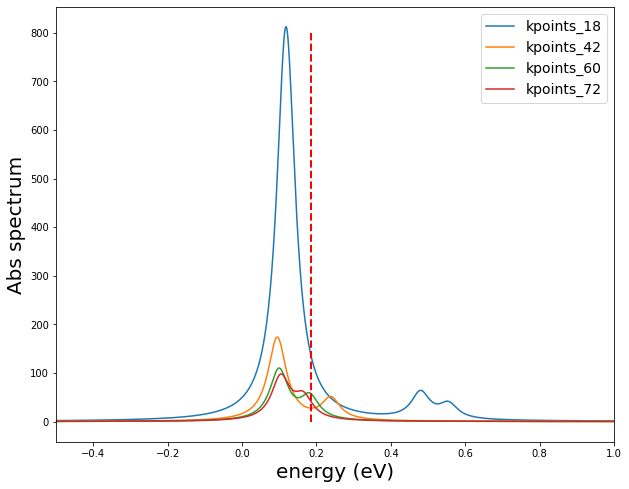

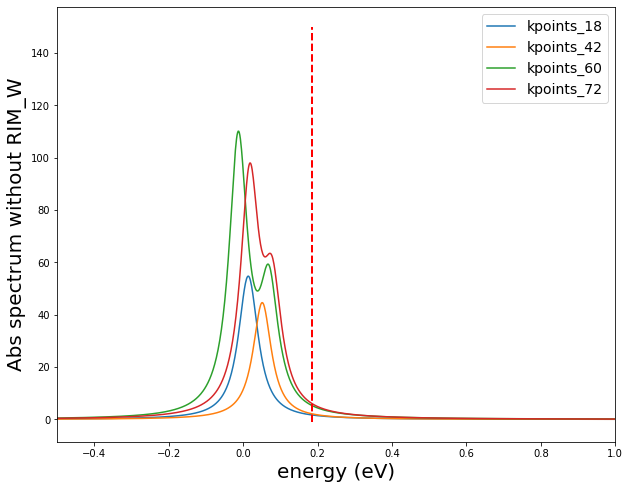

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(kpoints):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%s'%b) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(kpoints):
    data = results[ind+4].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%s'%b) 
ax.vlines(gw_gap,-1,150,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum without RIM_W',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)
plt.show()

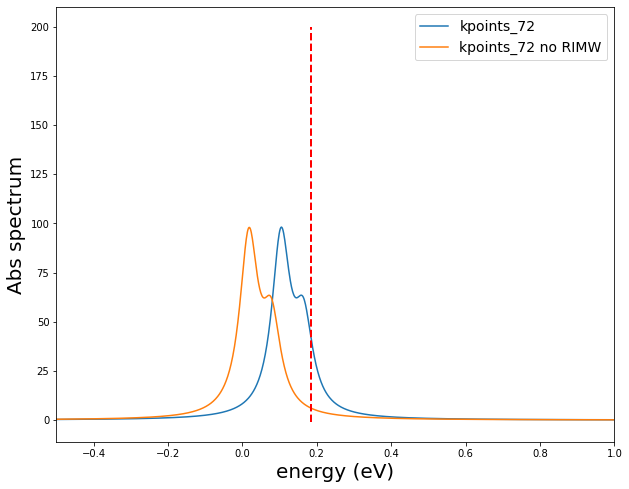

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[3].data['alpha_q1_slepc_bse']
energy = data['energy']
alpha_im = data['alpha_imag']

data = results[7].data['alpha_q1_slepc_bse']
energy = data['energy']
alpha_im_norimw = data['alpha_imag']

ax.plot(energy,alpha_im,label='kpoints_72') 
ax.plot(energy,alpha_im_norimw,label='kpoints_72 no RIMW') 
ax.vlines(gw_gap,-1,200,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)
plt.show()

In [44]:
energy[alpha_im.argmax()]-energy[alpha_im_norimw.argmax()]

0.087087

exc_eng [0.114346 0.093431 0.098148 0.1028  ]
bind_eng [0.069654 0.090569 0.085852 0.0812  ]
exc_eng_norimw [-0.002404  0.038019 -0.014247  0.016372]
bind_eng_norimw [0.186404 0.145981 0.198247 0.167628]


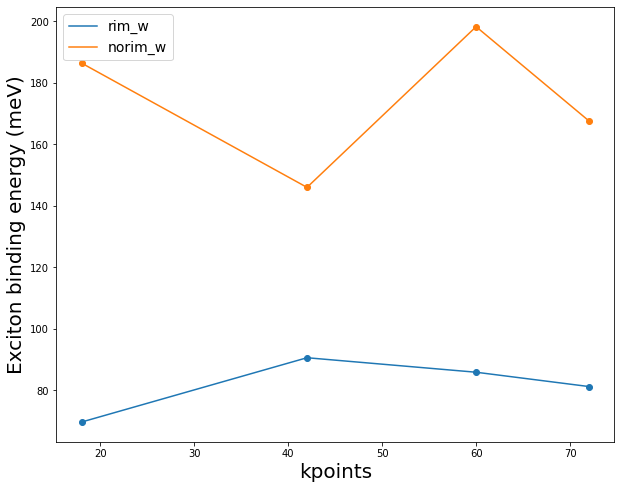

In [32]:
exc_eng = np.array([results[ind].data['Esort_q1_slepc_bse']['energy'][0] for ind in range(len(kpoints))])
exc_eng_norimw = np.array([results[ind+4].data['Esort_q1_slepc_bse']['energy'][0] for ind in range(len(kpoints))])

bind_eng = gw_gap-exc_eng
bind_eng_norimw = gw_gap-exc_eng_norimw
print('exc_eng',exc_eng)
print('bind_eng',bind_eng)

print('exc_eng_norimw',exc_eng_norimw)
print('bind_eng_norimw',bind_eng_norimw)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(kpoints,1e3*bind_eng,label='rim_w')
ax.scatter(kpoints,1e3*bind_eng)
ax.plot(kpoints,1e3*bind_eng_norimw,label='norim_w')
ax.scatter(kpoints,1e3*bind_eng_norimw)
ax.set_ylabel('Exciton binding energy (meV)',size=20)
ax.set_xlabel('kpoints',size=20)
ax.legend(fontsize=14)